# YELP DATASET


# Goal: Using user information to improve restaurants quality


### One: Review 
> #### Is there a common theme in users' first review? If yes, what is the prevelant theme? 

### Two: Elite User Program: 

> #### a. What factors make a user become elite? ( Quality vs Quantity ) 
>
#### b. Is there a trend in users'reviews? If yes, what subtopics they usually pay attention to? 
>
#### c. How many year each user maintain the elite status? 
>
#### d. Is there any user who has quality review and/or with high quantity that does not have elite status? Does it affect there loyalty for yelp?
>
#### e. Do most people leave reviews when they travel?

### Three: Tip 
> #### Correlation between tips & reviews. What makes one to leave tips? Tips predictions.


Dataset Source: https://www.yelp.com/dataset_challenge

In [4]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition.online_lda import LatentDirichletAllocation
import string
from sklearn.pipeline import Pipeline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# %load_ext sql

In [3]:
# !pip install ipython-sql

# Read Data

In [5]:
user = pd.read_csv('csv/user.csv')
business = pd.read_csv('csv/business.csv')
review = pd.read_csv('csv/review.csv')
tip = pd.read_csv('csv/tip.csv')

/Users/Charlotte/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,4,7,17,26,29,49,60,62,79,86,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
tip.head(2)

,user_id,text,business_id,likes,date,type
0,ZxdojCZgZhw36xuSGaryRg,Pizza is garbage. Hoagies are excellent.,5UmKMjUEUNdYWqANhGckJw,0,2016-07-17,tip
1,-6rEfobYjMxpUWLNxszaxQ,Don't waste your time.,cE27W9VPgO88Qxe4ol6y_g,0,2013-04-18,tip


In [2]:
# review.business_id.value_counts()

In [5]:
# from sqlalchemy import create_engine
# engine = create_engine('sqlite:///csv.db')
# conn = engine.connect()

In [7]:
def rename_column(file):
    new_names = list()
    for col in file:
        new_names.append(col.replace('.', '_', len(col)).replace(' ', '_', len(col)).lower())
    return new_names

In [8]:
user.columns = rename_column(user.columns)
business.columns = rename_column(business.columns)
business.columns = [ re.sub('attributes_', '', c) for c in business.columns ]
review.columns = rename_column(review.columns)

In [8]:
user = user.ix[user['review_count'] != 0]
user = user.drop(['type','friends'],axis = 1 )

In [9]:
review = review.drop('type',axis = 1)
business = business.drop('type',axis = 1)
tip = tip.drop('type',axis = 1)

In [10]:
user = user.reset_index()

In [11]:
user.tail(2)

,index,yelping_since,compliments_plain,review_count,compliments_cute,compliments_writer,fans,compliments_note,compliments_hot,compliments_cool,...,compliments_more,elite,name,user_id,votes_cool,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful
686541,686554,2016-02,NaN,1,NaN,NaN,0,NaN,NaN,NaN,...,NaN,[],MAureen,uRM8uxxbhum_Bedx1c1frw,1,NaN,0,NaN,NaN,2
686542,686555,2016-04,NaN,1,NaN,NaN,0,NaN,NaN,NaN,...,NaN,[],Amelia,DL0S4Ro4KY77akGPbEkrug,0,NaN,1,NaN,NaN,0


In [9]:
review.head(2)

,user_id,review_id,text,votes_cool,business_id,votes_funny,stars,date,type,votes_useful
0,PUFPaY9KxDAcGqfsorJp3Q,Ya85v4eqdd6k9Od8HbQjyA,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,review,0
1,Iu6AxdBYGR4A0wspR9BYHA,KPvLNJ21_4wbYNctrOwWdQ,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,review,0


In [11]:
len(review.text[0])

453

# Convert csv to sql database

In [12]:
# user.to_sql('user', conn)
# business.to_sql('business', conn)
# review.to_sql('review', conn)

# Data visualization

In [13]:
restaurant = business.categories.unique()

In [14]:
restaurant[0]

"['Fast Food', 'Restaurants']"

In [15]:
a = (re.search('Restaurant', restaurant[0]))
print(a)

<_sre.SRE_Match object; span=(15, 25), match='Restaurant'>


## Business Rating

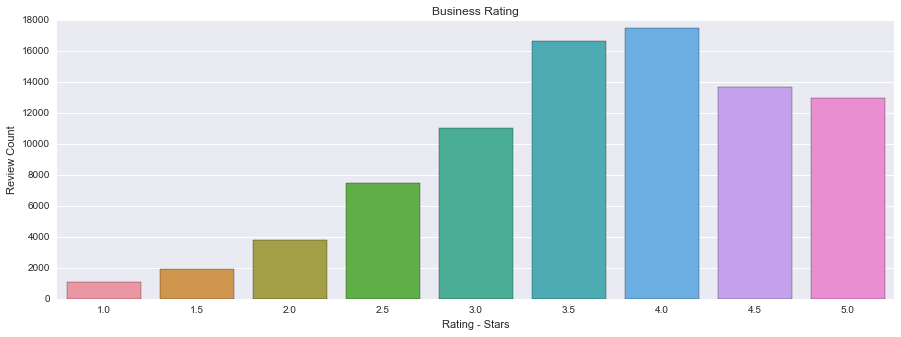

In [15]:
# plt.figure(figsize=(15,5))
# sns.countplot(business['stars'])
# plt.title('Business Rating')
# plt.xlabel('Rating - Stars')
# plt.ylabel('Review Count')

## Elite Status

In [16]:
# to find how many users in each elite year period
user['elite_year']  = [ len(i.split(',')) for i in user['elite']]

In [17]:
# plt.figure(figsize=(15,5))
# sns.countplot(user['elite_year'])
# plt.title('Distribution of Elite User')
# plt.xlabel('Year')
# plt.ylabel('User Count')

In [19]:
# plt.figure(figsize=(15,5))
# sns.countplot(user['elite_year'].ix[user['elite_year'] != 1])
# plt.title('Distribution of Elite User')
# plt.xlabel('Year')
# plt.ylabel('User Count')

# Number of years since  Yelp Membership Start Year until Elite Status

In [20]:
user['elite_since'] = [i.replace('[','').replace(']','').split(',')[0] for i in user['elite']]

In [21]:
user['elite_since'] = [int(i) if i!= '' else 0 for i in user['elite_since'] ]

In [22]:
user['year_before_elite'] = [ user['elite_since'][i] - int(user['yelping_since'][i].split("-")[0]) if  user['elite_since'][i]!= 0 else 0 for i in range(686543)]

In [23]:
# plt.figure(figsize=(15,5))
# sns.countplot(user['year_before_elite'].ix[user['year_before_elite']!= 0])
# plt.title('How long it takes Yelp User to become Elite User')
# plt.xlabel('Year')
# plt.ylabel('User Count')

In [24]:
# plt.figure(figsize=(15,5))
# sns.countplot(user['elite_since'].ix[user['elite_since']!= 0])
# plt.title('When user upgrade to Elite status')
# plt.xlabel('Year')
# plt.ylabel('User Count')

In [25]:
user['elite_since'].unique()

array([2005,    0, 2016, 2007, 2008, 2012, 2011, 2015, 2013, 2014, 2006,
       2010, 2009])

In [28]:
round((len(user) - 656772) * 100.0/ len(user),3) # percentage of elite users

4.336

In [26]:
elite_dict = Counter(user['year_before_elite'])

In [27]:
elite_pd = pd.DataFrame(list(elite_dict.items()),index = None,columns = ['year','user_count'])
elite_pd

,year,user_count
0,0,656772
1,1,10512
2,2,7187
3,3,4777
4,4,3320
5,5,2097
6,6,1047
7,7,553
8,8,206
9,9,57


In [28]:
member_since = user.groupby('yelping_since')['user_id'].count()
member_since = pd.DataFrame(member_since)

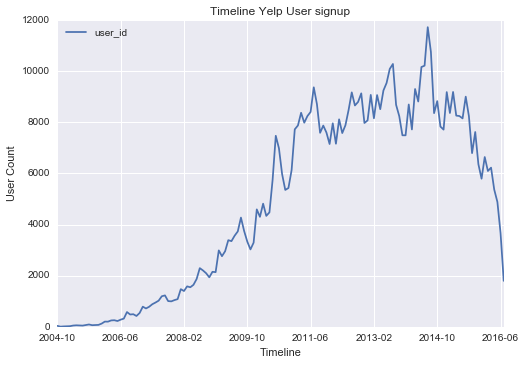

In [32]:
# member_since.plot()
# plt.title('Timeline Yelp User signup')
# plt.xlabel('Timeline')
# plt.ylabel('User Count')

# Review

In [ ]:
review.head(2)

In [29]:
a = Counter(review.user_id)
b = Counter(a.values()) # key : #review -- value: user count
b = dict(b)

In [30]:
c = pd.DataFrame(list(b.items()),index = None,columns = ['review','user_count'])
print(len(c))
c.head(2)

447


,review,user_count
0,1,360566
1,2,115750


In [31]:
c['percentage'] = [(c.user_count[i] * 100/sum(c.user_count)) for i in range(447)]

In [32]:
reviews_dict = dict()
label = ['one','two','three']
for i,label in enumerate(label):
    reviews_dict[label] = c.percentage[i]

In [33]:
reviews_dict['four_ten']= sum(c.percentage[3:10])
reviews_dict['tens']= sum(c.percentage[10:100])
reviews_dict['more_than_hundred']= sum(c.percentage[100:-1])

In [34]:
reviews_dict

{'four_ten': 15.839057556848969,
 'more_than_hundred': 0.244699631202698,
 'one': 52.518075728709675,
 'tens': 5.975477601244473,
 'three': 8.5630305466706282,
 'two': 16.859513280781176}

In [35]:
review_pd = pd.DataFrame(list(reviews_dict.items()),index = None,columns = ['review','user_percentage'])
review_pd

,review,user_percentage
0,more_than_hundred,0.244700
1,three,8.563031
2,four_ten,15.839058
3,two,16.859513
4,one,52.518076
5,tens,5.975478


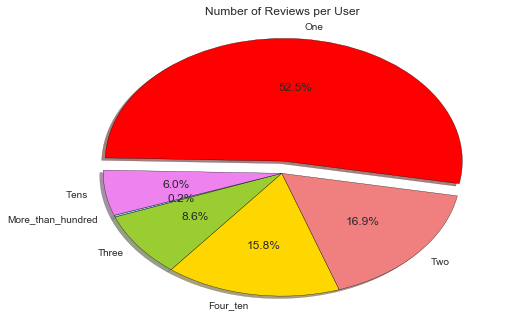

In [36]:
labels =[ i.capitalize() for i in  review_pd['review']]
sizes = review_pd['user_percentage']
colors = ['lightskyblue','yellowgreen', 'gold', 'lightcoral','red','violet']
explode = (0, 0, 0,0,.1, 0) 

plt.pie(sizes, explode=explode,labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=200,center=(0,1));
plt.title('Number of Reviews per User')

# Filter business category to restaurant only

In [37]:
# create a dataframe with business id and category
all_businesses = pd.concat([business['business_id'], business['categories']], axis=1, keys=['business_id', 'category'])

In [38]:
all_businesses.head(3)

,business_id,category
0,5UmKMjUEUNdYWqANhGckJw,"['Fast Food', 'Restaurants']"
1,UsFtqoBl7naz8AVUBZMjQQ,['Nightlife']
2,cE27W9VPgO88Qxe4ol6y_g,"['Active Life', 'Mini Golf', 'Golf']"


In [39]:
# get index of businesses that are not restaurants
not_restaurant = [i for i,e in enumerate(all_businesses.values) if "Restaurant" not in e[1]]

In [40]:
all_businesses.drop(all_businesses.index[not_restaurant], inplace=True)

In [41]:
restaurant = all_businesses # after dropping all businesses that are not restaurants 

In [42]:
restaurant = restaurant.reset_index() # reset the index 

In [43]:
restaurant = restaurant.drop('index',axis = 1) # drop the old index 

In [44]:
restaurant.head(2)

,business_id,category
0,5UmKMjUEUNdYWqANhGckJw,"['Fast Food', 'Restaurants']"
1,mVHrayjG3uZ_RLHkLj-AMg,"['Bars', 'American (New)', 'Nightlife', 'Loung..."


In [45]:
# len(restaurant) # 26729 -- number of businesses
# len(restaurant.category.unique()) #4318--- number of unique categories 

In [46]:
k = Counter(restaurant.category) # 4318 -- Count number of businesses / unique category --- most categories are very similar 

In [47]:
label = [k for k,v in k.items() if v >100] # 41 --- get the label that has more than 100 businesses

In [48]:
label[:5]

["['Breakfast & Brunch', 'Restaurants']",
 "['Greek', 'Mediterranean', 'Restaurants']",
 "['Vietnamese', 'Restaurants']",
 "['Sandwiches', 'Restaurants']",
 "['Sushi Bars', 'Japanese', 'Restaurants']"]

In [49]:
review.head(2)

,user_id,review_id,text,votes_cool,business_id,votes_funny,stars,date,votes_useful
0,PUFPaY9KxDAcGqfsorJp3Q,Ya85v4eqdd6k9Od8HbQjyA,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,0
1,Iu6AxdBYGR4A0wspR9BYHA,KPvLNJ21_4wbYNctrOwWdQ,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,0


In [50]:
restaurant.head(2)

,business_id,category
0,5UmKMjUEUNdYWqANhGckJw,"['Fast Food', 'Restaurants']"
1,mVHrayjG3uZ_RLHkLj-AMg,"['Bars', 'American (New)', 'Nightlife', 'Loung..."


In [51]:
len(review)

2685066

# Get Reviews for Restaurants only

In [52]:
review_indices = review['business_id'].isin(restaurant['business_id'])

In [53]:
restaurant_review = review[review_indices]

In [54]:
restaurant_review.head(2)

,user_id,review_id,text,votes_cool,business_id,votes_funny,stars,date,votes_useful
0,PUFPaY9KxDAcGqfsorJp3Q,Ya85v4eqdd6k9Od8HbQjyA,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,0
1,Iu6AxdBYGR4A0wspR9BYHA,KPvLNJ21_4wbYNctrOwWdQ,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,0


In [1]:
review_count = Counter(restaurant_review['business_id']) ### number of restaurants
print(len(review_count))
top_restaurant = [(k,v)for k,v in review_count.items() if v > 300]#number of restaurants that have more than 300 reviews
top_restaurant[:10]
sorted_by_second = sorted(top_restaurant, key=lambda tup: tup[1])
sorted_by_second[-5:]

NameError: name 'Counter' is not defined

In [56]:
sum([i[1] for i in sorted_by_second])

557659

In [38]:
business.ix[business['business_id'] == 'dcd3C1gWv-vVdQ9XYV8Ubw']

,attributes.Ambience.divey,attributes.Dietary Restrictions.vegan,attributes.Happy Hour,hours.Thursday.open,attributes.Order at Counter,attributes.Hair Types Specialized In.africanamerican,attributes.Hair Types Specialized In.kids,attributes.BYOB,hours.Friday.open,attributes.Good For.latenight,...,attributes.Noise Level,attributes.Smoking,attributes.Attire,attributes.Hair Types Specialized In.curly,attributes.Good For Groups,neighborhoods,attributes.Open 24 Hours,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale
15883,False,False,NaN,11:00,NaN,NaN,NaN,False,11:00,False,...,average,NaN,casual,NaN,True,[],NaN,False,NaN,False


In [39]:
selected_restaurants = pd.DataFrame(sorted_by_second,columns = ['business_id','review_count'])

In [40]:
selected_restaurants.tail()

,business_id,review_count
932,2e2e7WgqU1BnpxmQL5jbfw,4103
933,aGbjLWzcrnEx2ZmMCFm3EA,4149
934,zt1TpTuJ6y9n551sw9TaEg,4333
935,sIyHTizqAiGu12XMLX3N3g,4531
936,4bEjOyTaDG24SY5TxsaUNQ,5558


In [45]:
# self.SVD_matrix = np.zeros(shape = (944, 1683), dtype = np.float32)
# def modifyRatingsDataset(self): 
#         ''' Assign rating values to a matrix (userid, movieid ) '''
#         for index, row in self.ratings.iterrows():
#             self.SVD_matrix[ int(row[0]) , int(row[1])] = float(row[2])
#         return csc_matrix(self.SVD_matrix, dtype=np.float32),self.SVD_matrix

In [46]:
len(restaurant_review)

1630712

In [81]:
restaurant_review['text']  =  [re.sub('['+string.punctuation+']', '', i.lower().replace('\n','')) for i in restaurant_review['text']]

/Users/Charlotte/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [48]:
restaurant_review['text'][0]

'mr hoagie is an institution walking in it does seem like a throwback to 30 years ago old fashioned menu board booths out of the 70s and a large selection of food their speciality is the italian hoagie and it is voted the best in the area year after year i usually order the burger while the patties are obviously cooked from frozen all of the other ingredients are very fresh overall its a good alternative to subway which is down the road'

In [57]:
len(restaurant_review)

1630712

In [62]:
user.columns

Index(['index', 'yelping_since', 'compliments_plain', 'review_count',
       'compliments_cute', 'compliments_writer', 'fans', 'compliments_note',
       'compliments_hot', 'compliments_cool', 'compliments_profile',
       'average_stars', 'compliments_more', 'elite', 'name', 'user_id',
       'votes_cool', 'compliments_list', 'votes_funny', 'compliments_photos',
       'compliments_funny', 'votes_useful', 'elite_year', 'elite_since',
       'year_before_elite'],
      dtype='object')

In [90]:
user.ix[user['user_id'] == 'OOzsB8nI8MgD5G-egvstGw']

,index,yelping_since,compliments_plain,review_count,compliments_cute,compliments_writer,fans,compliments_note,compliments_hot,compliments_cool,...,user_id,votes_cool,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful,elite_year,elite_since,year_before_elite
219715,219719,2008-05,7.0,199,NaN,3.0,8,3.0,2.0,6.0,...,OOzsB8nI8MgD5G-egvstGw,28,NaN,25,NaN,NaN,130,2,2011,3


In [92]:
elite_user = (user['user_id'].ix[user['elite_since'] != 0])

In [93]:
not_elite_user = (user['user_id'].ix[user['elite_since'] == 0])

In [74]:
elite_index = user[user['elite_since'] != 0].index.tolist()

In [91]:
# not_elite_index = user[user['elite_since'] == 0].index.tolist()

In [83]:
review_index = restaurant_review['user_id'].isin(elite_user )

In [94]:
not_elite_index = restaurant_review['user_id'].isin(not_elite_user)

In [84]:
elite_review = restaurant_review[review_index ]

In [ ]:
not_elite_review = restaurant_review[not_elite_index]

In [88]:
elite_review['user_id'].value_counts()

9A2-wSoBUxlMd3LwmlGrrQ    937
3gIfcQq5KxAegwCPXc83cQ    813
Iu3Jo9ROp2IWC9FwtWOaUQ    729
pEVf8GRshP9HUkSpizc9LA    689
ia1nTRAQEaFWv0cwADeK7g    682
kGgAARL2UmvCcTRfiscjug    665
uZbTb-u-GVjTa2gtQfry5g    650
glRXVWWD6x1EZKfjJawTOg    611
5lq4LkrviYgQ4LJNsBYHcA    569
0bNXP9quoJEgyVZu9ipGgQ    541
C6IOtaaYdLIT5fWd7ZYIuA    513
90a6z--_CUrl84aCzZyPsg    501
_PzSNcfrCjeBxSLXRoMmgQ    500
fczQCSmaWF78toLEmb0Zsw    482
PV5voYSD43Cn_3gHmxG7DA    478
k5p3YP1ZjCa8ZS3xqXgBug    473
-_1ctLaz3jhPYc12hKXsEQ    471
XqMkm-DD9VsdcKx2YVGhSA    437
WmAyExqSWoiYZ5XEqpk_Uw    429
OaFcpi3W4AwxrD8W2pgC_A    420
4G68oLRY3aHE5XUt_MUUcA    411
T7J9ae0wTskrI_Bgwp-4cA    405
VhI6xyylcAxi0wOy2HOX3w    400
4ozupHULqGyO42s3zNUzOQ    398
qqtmFGhyyHc37coT4qJxaw    385
GrSixRnGIxNUJ1Cn5DNX9A    384
m7vtKWpZ9wdEQ95wJxrMrg    378
lPaYMDmJbAnv_3pmZH_inw    378
Kqvfep2mxS10S50FbVDi4Q    378
M6oU3OBf_E6gqlfkLGlStQ    377
                         ... 
OOzsB8nI8MgD5G-egvstGw      1
fBh8nGMOjsZ1DOYQKNxfCQ      1
HOLG-LUPZo

# Export to pickle

In [58]:
# restaurant_review.to_pickle('data/review') 
# business.to_pickle('data/business')
# user.to_pickle('data/user')


In [55]:
# checking = pd.read_pickle('csv/test')
# # checking = pd.read_csv('csv/restaurant_review.csv')


In [57]:
restaurant.head(2)

,business_id,category
0,5UmKMjUEUNdYWqANhGckJw,"['Fast Food', 'Restaurants']"
1,mVHrayjG3uZ_RLHkLj-AMg,"['Bars', 'American (New)', 'Nightlife', 'Loung..."


In [284]:
def days_late_xform(dl):
    if dl > 500: return 'more_1000'
    elif 300 < dl <= 500: return 'f'
    elif 100 < dl <= 300: return 'd'
    elif 80 < dl <= 100: return 'd'
    elif 50 < dl <= 80: return 'c'
    elif 20 < dl <= 50: return 'b'
    elif 10 < dl <= 20: return '10_20'
    elif 5 < dl <= 10: return '5_10'
    elif 2 < dl <= 3: return 'three'
    elif 1 < dl <= 2: return 'two'
    elif 0 < dl <= 1: return 'one'
    else: return 'None'

k = df['count'].map(days_late_xform)

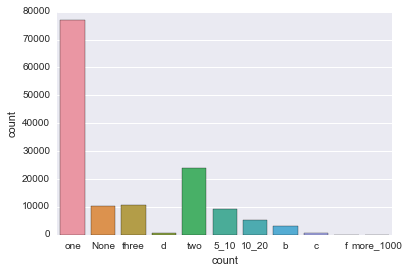

In [285]:
plt.figure(figsize=(15,5))
sns.countplot(k.ix[k != "i"])